In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import skew, kurtosis, probplot
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from lightgbm import LGBMRegressor
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import plotly.graph_objects as go
import joblib

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [5]:
df = pd.read_csv("df_final_ML2.csv")

### Conversions 

In [7]:
#Convertir la colonne Date en datetime
df["Date"] = pd.to_datetime(df["Date"])

#Convertir la colonne Code INSEE région en object
df['Code INSEE région'] = df['Code INSEE région'].astype('object')

#Convertir la colonne Loi energie climat 2019 en integer

df['Loi energie climat 2019'] = df['Loi energie climat 2019'].astype('int')

### Feature engineering 

En plus des variables temporelles ajoutés dans la partie data management (jour, mois, année, sinus, cosinus, etc), nous allons également procéder à la construction de lags

In [9]:
# Ajout des lags pour la consommation d'énergie jusqu'à 90 jours
for lag in [1, 7, 30, 60, 90, 365]:  # Lags de 1, 7, 30, 60 et 90 jours
    df[f'lag_{lag}_Consommation'] = df['Consommation (MWh)'].shift(lag)

# Ajout des lags pour les variables climatiques jusqu'à 90 jours
for lag in [1, 7, 30, 60, 90]:
    df[f'lag_{lag}_TMin'] = df['TMin (°C)'].shift(lag)
    df[f'lag_{lag}_TMax'] = df['TMax (°C)'].shift(lag)
    df[f'lag_{lag}_TMoy'] = df['TMoy (°C)'].shift(lag)
    df[f'lag_{lag}_Vitesse_vent'] = df['Vitesse du vent à 100m (m/s)'].shift(lag)
    df[f'lag_{lag}_Rayonnement'] = df['Rayonnement solaire global (W/m2)'].shift(lag)

# Supprimer les valeurs manquantes créées par les lags
df = df.dropna()

In [11]:
df = df.sort_values(['Code INSEE région', 'Date'])

# Définir les fenêtres de rolling
windows = [7, 30, 90]  # 7 jours, 30 jours, 90 jours

for window in windows:
    df[f'Consommation_rolling_mean_{window}'] = df.groupby('Code INSEE région')['Consommation (MWh)'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())

#Gestion des NA : 

# Remplir les NaN avec la méthode de forward fill **par région**
df['Consommation_rolling_mean_7'] = df.groupby('Code INSEE région')['Consommation_rolling_mean_7'].fillna(method='ffill')
df['Consommation_rolling_mean_30'] = df.groupby('Code INSEE région')['Consommation_rolling_mean_30'].fillna(method='ffill')
df['Consommation_rolling_mean_90'] = df.groupby('Code INSEE région')['Consommation_rolling_mean_90'].fillna(method='ffill')


### Gestion des outliers

In [13]:
# Calculer Q1, Q3 et l'IQR pour la target
Q1 = df['Consommation (MWh)'].quantile(0.25)
Q3 = df['Consommation (MWh)'].quantile(0.75)
IQR = Q3 - Q1

# Identifier les outliers dans la consommation
outliers = (df['Consommation (MWh)'] < (Q1 - 1.5 * IQR)) | (df['Consommation (MWh)'] > (Q3 + 1.5 * IQR))

# Supprimer les lignes avec outliers dans la target
df_cleaned = df[~outliers]

### Corrélations avec la target

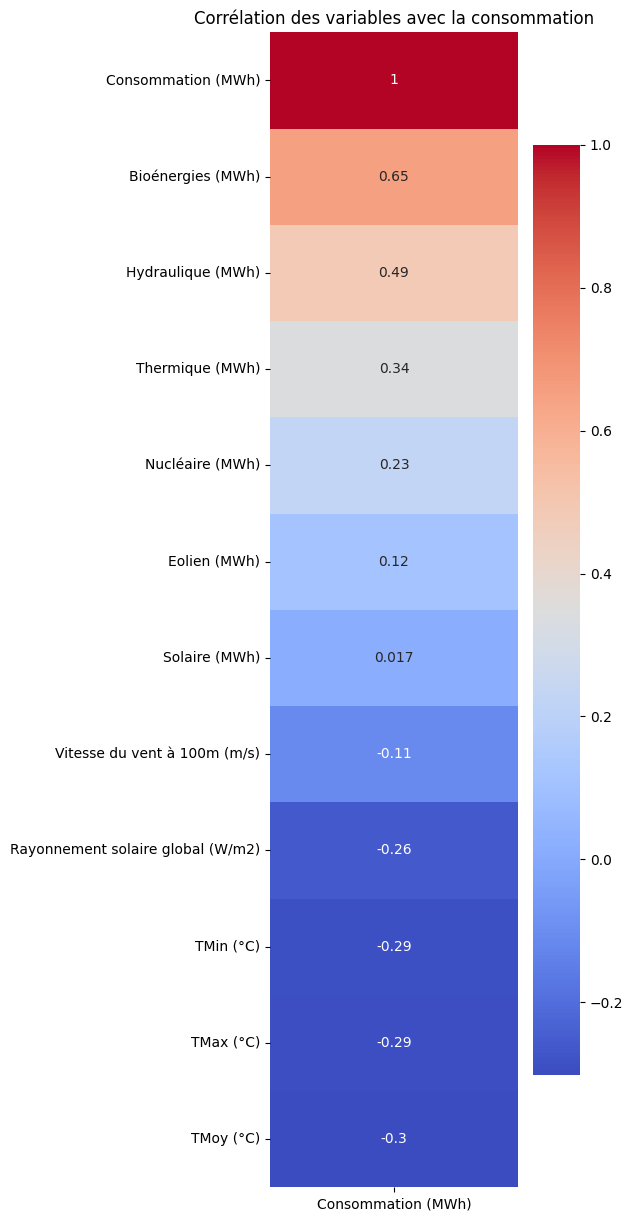

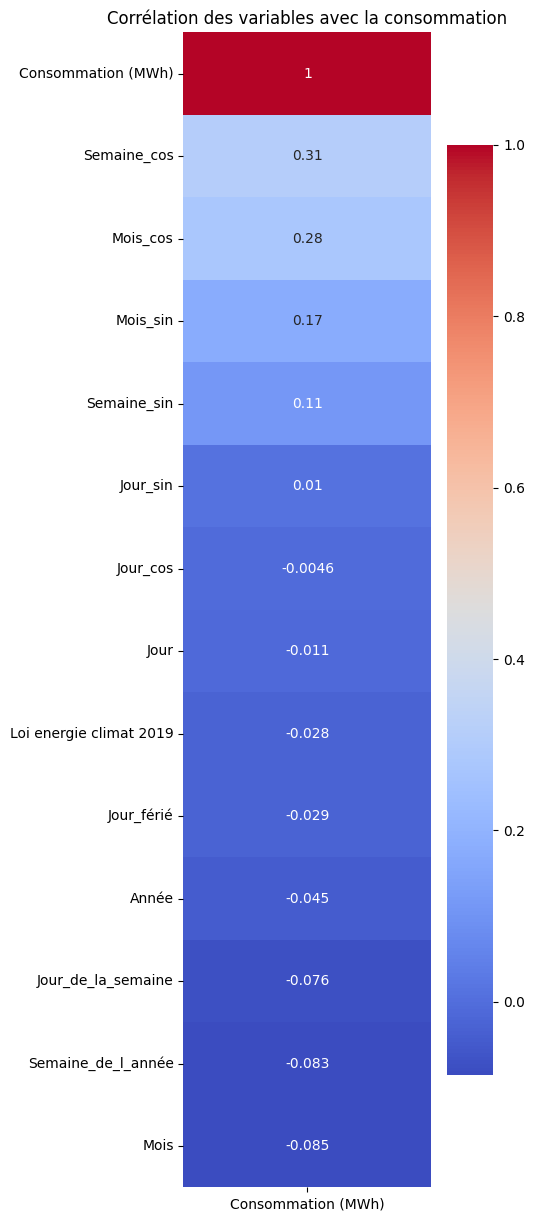

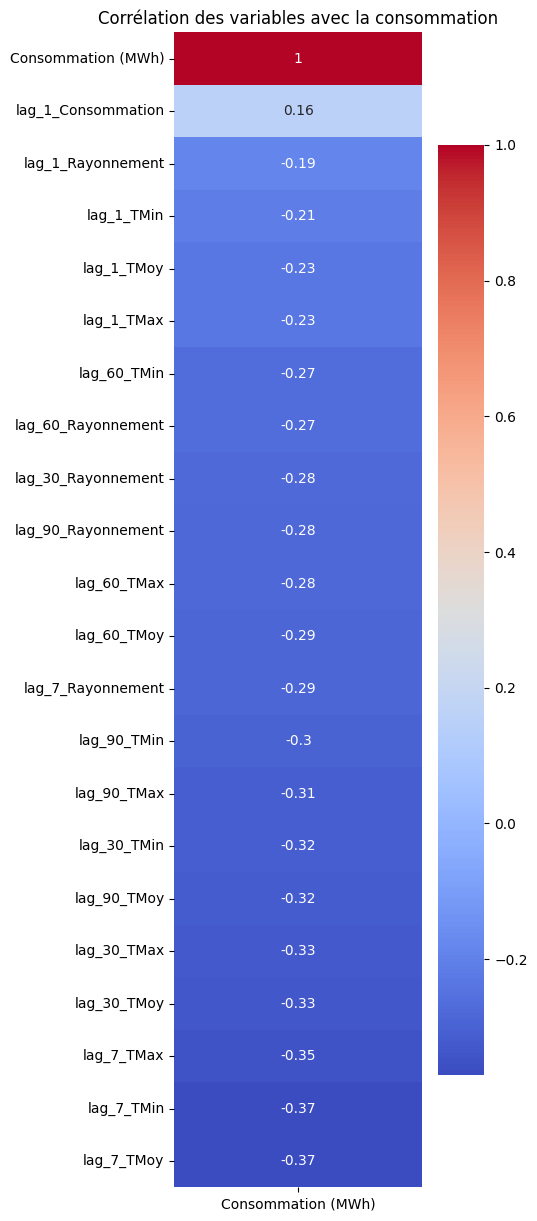

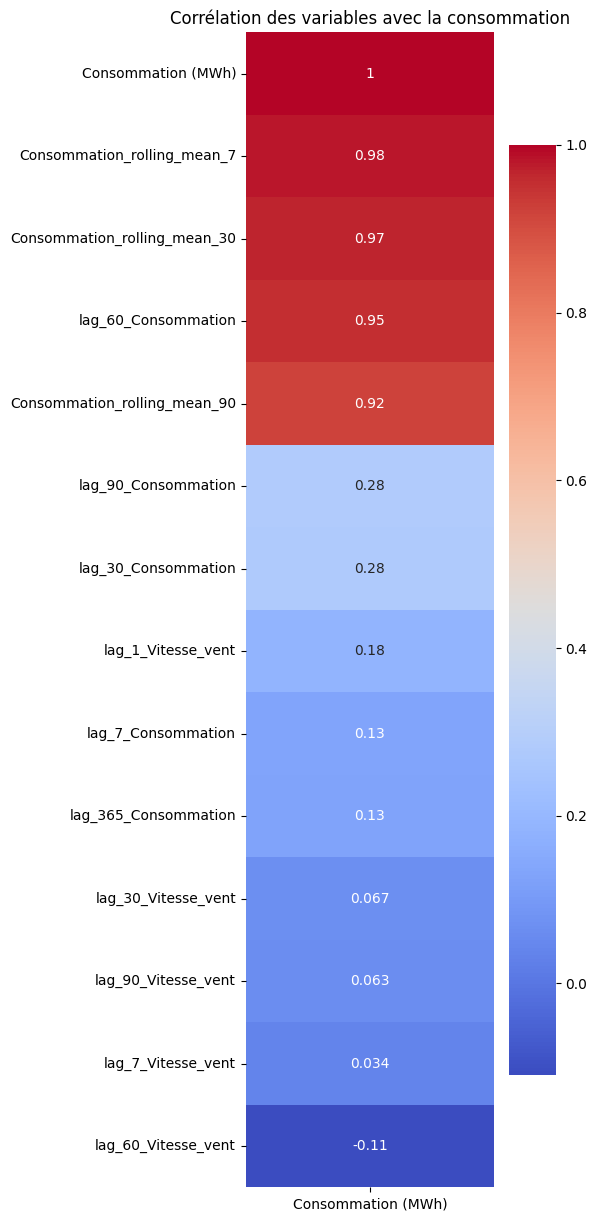

In [15]:
# Séparer les colonnes en trois groupes
group_1 = ['Consommation (MWh)', 'Thermique (MWh)', 'Nucléaire (MWh)', 'Eolien (MWh)', 'Solaire (MWh)', 
           'Hydraulique (MWh)', 'Bioénergies (MWh)', 'TMin (°C)', 'TMax (°C)', 'TMoy (°C)', 'Vitesse du vent à 100m (m/s)', 
           'Rayonnement solaire global (W/m2)']

group_2 = ['Consommation (MWh)','Jour', 'Mois', 'Année', 'Semaine_de_l_année', 'Jour_de_la_semaine', 'Jour_férié', 
           'Semaine_sin', 'Semaine_cos', 'Jour_sin', 'Jour_cos', 'Mois_sin', 'Mois_cos', 'Loi energie climat 2019']

group_3 = ['Consommation (MWh)','lag_1_Consommation', 
           'lag_1_TMin', 'lag_1_TMax', 'lag_1_TMoy',  'lag_1_Rayonnement', 
           'lag_7_TMin', 'lag_7_TMax', 'lag_7_TMoy',  'lag_7_Rayonnement', 
           'lag_30_TMin', 'lag_30_TMax', 'lag_30_TMoy',  'lag_30_Rayonnement',
           'lag_60_TMin', 'lag_60_TMax', 'lag_60_TMoy', 'lag_60_Rayonnement',
           'lag_90_TMin', 'lag_90_TMax', 'lag_90_TMoy',  'lag_90_Rayonnement']

group_4 = ['Consommation (MWh)', 'lag_1_Vitesse_vent','lag_7_Vitesse_vent','lag_30_Vitesse_vent', 'lag_60_Vitesse_vent', 'lag_90_Vitesse_vent',
          'lag_7_Consommation', 'lag_30_Consommation', 'lag_60_Consommation', 'lag_90_Consommation', 'lag_365_Consommation', 'Consommation_rolling_mean_7', 
         'Consommation_rolling_mean_30', 'Consommation_rolling_mean_90']

# Calcul de la matrice de corrélation
corr_matrix1 = df_cleaned[group_1].corr()
corr_matrix2 = df_cleaned[group_2].corr()
corr_matrix3 = df_cleaned[group_3].corr()
corr_matrix4 = df_cleaned[group_4].corr()

# Fonction pour afficher une sous-matrice de corrélation
def plot_corr_matrix(corr_matrix, title):
    plt.figure(figsize=(4, 15))
    sns.heatmap(corr_matrix[['Consommation (MWh)']].sort_values(by='Consommation (MWh)', ascending=False), annot=True, cmap="coolwarm")
    plt.title("Corrélation des variables avec la consommation")
    plt.show()

# Afficher la matrice de corrélation pour chaque groupe
plot_corr_matrix(corr_matrix1,  'Matrice de Corrélation - Groupe 1')
plot_corr_matrix(corr_matrix2, 'Matrice de Corrélation - Groupe 2')
plot_corr_matrix(corr_matrix3, 'Matrice de Corrélation - Groupe 3')
plot_corr_matrix(corr_matrix4, 'Matrice de Corrélation - Groupe 4')


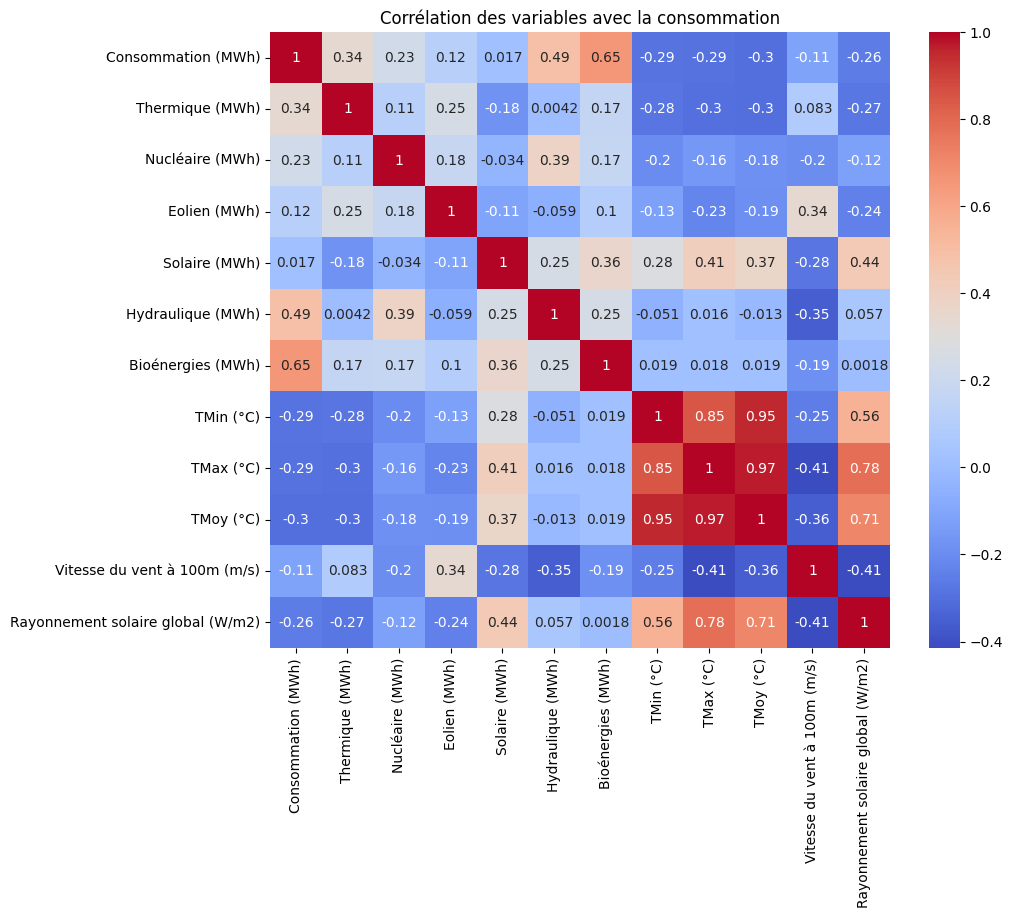

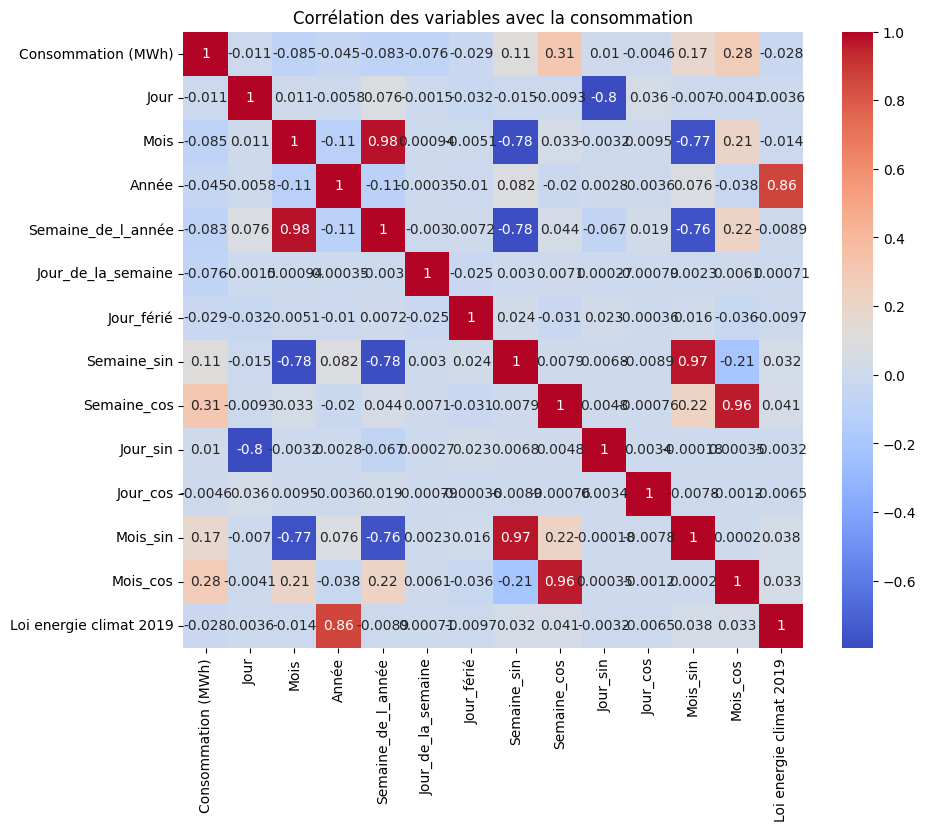

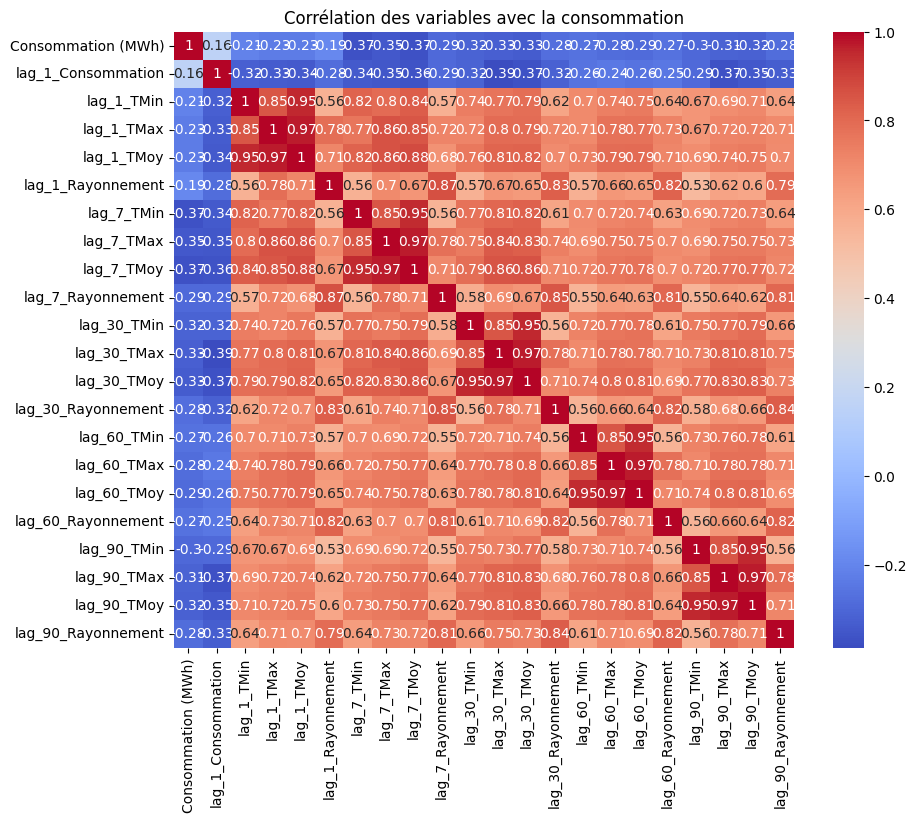

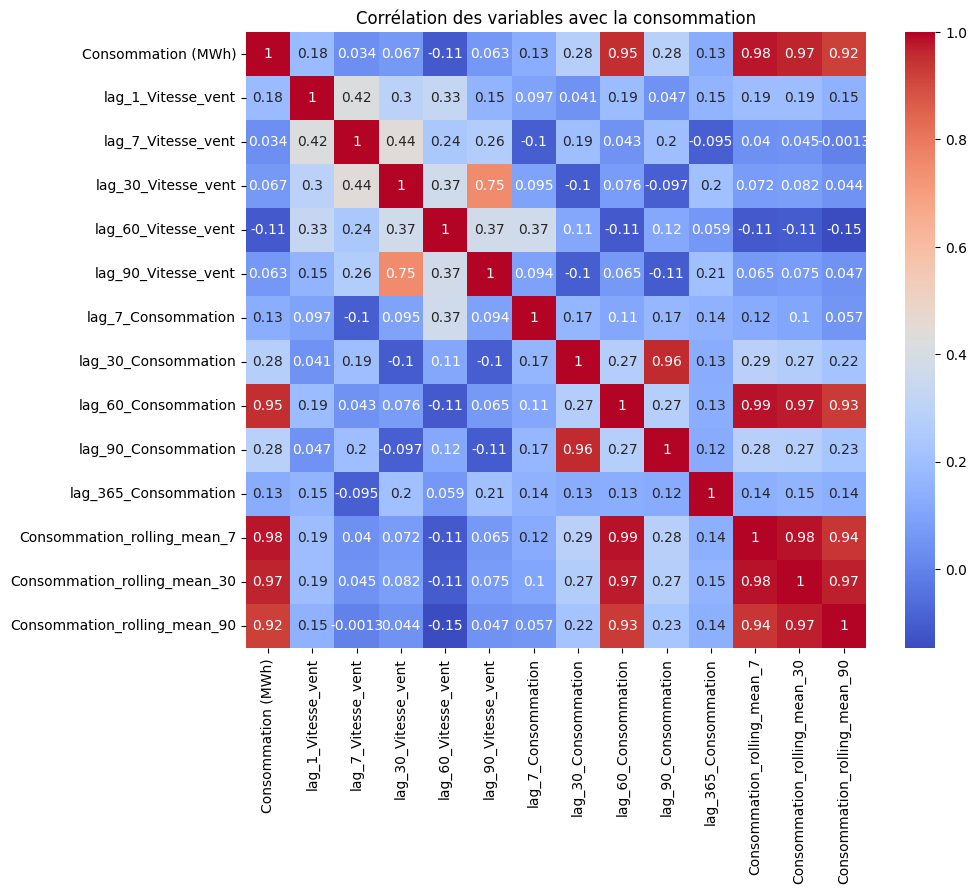

In [17]:
# Séparer les colonnes en trois groupes
group_1 = ['Consommation (MWh)', 'Thermique (MWh)', 'Nucléaire (MWh)', 'Eolien (MWh)', 'Solaire (MWh)', 
           'Hydraulique (MWh)', 'Bioénergies (MWh)', 'TMin (°C)', 'TMax (°C)', 'TMoy (°C)', 'Vitesse du vent à 100m (m/s)', 
           'Rayonnement solaire global (W/m2)']

group_2 = ['Consommation (MWh)','Jour', 'Mois', 'Année', 'Semaine_de_l_année', 'Jour_de_la_semaine', 'Jour_férié', 
           'Semaine_sin', 'Semaine_cos', 'Jour_sin', 'Jour_cos', 'Mois_sin', 'Mois_cos', 'Loi energie climat 2019']

group_3 = ['Consommation (MWh)','lag_1_Consommation', 
           'lag_1_TMin', 'lag_1_TMax', 'lag_1_TMoy',  'lag_1_Rayonnement', 
           'lag_7_TMin', 'lag_7_TMax', 'lag_7_TMoy',  'lag_7_Rayonnement', 
           'lag_30_TMin', 'lag_30_TMax', 'lag_30_TMoy',  'lag_30_Rayonnement',
           'lag_60_TMin', 'lag_60_TMax', 'lag_60_TMoy', 'lag_60_Rayonnement',
           'lag_90_TMin', 'lag_90_TMax', 'lag_90_TMoy',  'lag_90_Rayonnement']

group_4 = ['Consommation (MWh)', 'lag_1_Vitesse_vent','lag_7_Vitesse_vent','lag_30_Vitesse_vent', 'lag_60_Vitesse_vent', 'lag_90_Vitesse_vent',
          'lag_7_Consommation', 'lag_30_Consommation', 'lag_60_Consommation', 'lag_90_Consommation', 'lag_365_Consommation','Consommation_rolling_mean_7', 
         'Consommation_rolling_mean_30', 'Consommation_rolling_mean_90']

# Calcul de la matrice de corrélation
corr_matrix1 = df_cleaned[group_1].corr()
corr_matrix2 = df_cleaned[group_2].corr()
corr_matrix3 = df_cleaned[group_3].corr()
corr_matrix4 = df_cleaned[group_4].corr()

# Fonction pour afficher une sous-matrice de corrélation
def plot_corr_matrix(corr_matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
    plt.title("Corrélation des variables avec la consommation")
    plt.show()

# Afficher la matrice de corrélation pour chaque groupe
plot_corr_matrix(corr_matrix1,  'Matrice de Corrélation - Groupe 1')
plot_corr_matrix(corr_matrix2, 'Matrice de Corrélation - Groupe 2')
plot_corr_matrix(corr_matrix3, 'Matrice de Corrélation - Groupe 3')
plot_corr_matrix(corr_matrix4, 'Matrice de Corrélation - Groupe 4')

### Train / test split et transformations

In [15]:
df_transformed = df_cleaned.copy() #copier le data set pour ne pas écraser les modifications

In [17]:
# Séparer la target (y) des features (X)
df_transformed = df_transformed.sort_values(by=['Date', 'Code INSEE région']).\
  reset_index(drop=True)

X = df_transformed[['Région','Thermique (MWh)', 
       'Hydraulique (MWh)', 'Bioénergies (MWh)', 
       'TMoy (°C)', 'Semaine_cos','Semaine_sin', 'lag_7_Consommation', 'lag_30_Consommation', 'lag_365_Consommation', 
                    'lag_7_TMoy', 'Consommation_rolling_mean_7']]

y = df_transformed['Consommation (MWh)']

# Split train/test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)#shuffle = False pour conserver l'ordre chronologique

In [19]:
#Encodage de la variable Région
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit uniquement sur X_train et transformer X_train
X_train_encoded = encoder.fit_transform(X_train[['Région']])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(['Région']), index=X_train.index)

# Transformer X_test (sans refit)
X_test_encoded = encoder.transform(X_test[['Région']])
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(['Région']), index=X_test.index)

# Concaténer les colonnes encodées avec les autres features
X_train = pd.concat([X_train.drop(columns=['Région']), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(columns=['Région']), X_test_encoded_df], axis=1)

In [21]:
# Concaténer X_train et y_train pour faciliter l'analyse
df_train = X_train[['Région_Auvergne-Rhône-Alpes',
       'Région_Bourgogne-Franche-Comté', 'Région_Bretagne',
       'Région_Centre-Val de Loire', 'Région_Grand Est',
       'Région_Hauts-de-France', 'Région_Normandie',
       'Région_Nouvelle-Aquitaine', 'Région_Occitanie',
       'Région_Pays de la Loire', "Région_Provence-Alpes-Côte d'Azur",
       'Région_Île-de-France']].copy()
df_train['Consommation (MWh)'] = y_train  

# Calculer la corrélation de chaque feature avec la target
correlations = df_train.corr()['Consommation (MWh)'].drop('Consommation (MWh)')  

# Trier par ordre décroissant d'importance absolue
correlations = correlations.abs().sort_values(ascending=False)

# Afficher les variables les plus corrélées
print(correlations)


Région_Auvergne-Rhône-Alpes          0.452152
Région_Île-de-France                 0.438790
Région_Centre-Val de Loire           0.353461
Région_Bourgogne-Franche-Comté       0.305078
Région_Bretagne                      0.284825
Région_Hauts-de-France               0.215121
Région_Pays de la Loire              0.198573
Région_Normandie                     0.188714
Région_Grand Est                     0.132741
Région_Nouvelle-Aquitaine            0.098058
Région_Provence-Alpes-Côte d'Azur    0.045452
Région_Occitanie                     0.004412
Name: Consommation (MWh), dtype: float64


In [23]:
#Garder uniquement les régions avec une corrélation supérieur à 0.30
X_train = X_train.drop(columns=['Région_Bretagne',
        'Région_Grand Est','Région_Hauts-de-France', 'Région_Normandie',
       'Région_Nouvelle-Aquitaine', 'Région_Occitanie',
       'Région_Pays de la Loire', "Région_Provence-Alpes-Côte d'Azur"
       ])

X_test = X_test.drop(columns=['Région_Bretagne',
        'Région_Grand Est','Région_Hauts-de-France', 'Région_Normandie',
       'Région_Nouvelle-Aquitaine', 'Région_Occitanie',
       'Région_Pays de la Loire', "Région_Provence-Alpes-Côte d'Azur"
       ])

In [25]:
# Colonnes numériques à standardiser
normalize_cols = ['Thermique (MWh)', 
       'Hydraulique (MWh)', 'Bioénergies (MWh)', 
       'TMoy (°C)',  'lag_7_Consommation', 'lag_30_Consommation', 'lag_365_Consommation', 
                    'lag_7_TMoy', 'Consommation_rolling_mean_7']

# Initialisation des scalers
scaler_X = StandardScaler()

# Standardiser X_train 
X_train[normalize_cols] = scaler_X.fit_transform(X_train[normalize_cols])

# Appliquer la transformation sur  X_test (sans refit)
X_test[normalize_cols] = scaler_X.transform(X_test[normalize_cols])


In [27]:
X_train.to_csv("X_train_vf2.csv", index=False)

### Entraînement du premier modèle ML XGBoost

Utilisation de grid search pour nous aider dans le choix des hyperparamètres

In [370]:
# Définir le modèle XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Définir les hyperparamètres à tester avec GridSearchCV
param_grid = {
    'n_estimators': [400, 500],  # Nombre d'estimateurs
    'learning_rate': [0.01, 0.05, 0.1],  # Taux d'apprentissage
    'max_depth': [5, 6, 7],  # Profondeur des arbres
    'colsample_bytree': [0.7, 0.8, 1.0],  # Proportion de features pour chaque arbre
    'gamma': [0, 0.3],  # Lutte contre l’overfitting en contrôlant les branches des arbres
}

# GridSearchCV : recherche exhaustive des meilleurs paramètres
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=3, scoring='neg_mean_absolute_error', 
                           n_jobs=-1, verbose=1)

# Entraîner le modèle avec la recherche sur la grille
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres trouvés
print(f"Meilleurs paramètres : {grid_search.best_params_}")

# Utiliser le modèle optimal pour faire des prédictions
best_model_xgb = grid_search.best_estimator_

# Validation croisée avec TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

mae_scores, mse_scores, mape_scores, r2_scores = [], [], [], []

for train_index, test_index in tscv.split(X_train):
    X_train_iter, X_test_iter = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_iter, y_test_iter = y_train.iloc[train_index], y_train.iloc[test_index]

    # Entraînement avec le meilleur modèle trouvé par GridSearchCV
    best_model_xgb.fit(X_train_iter, y_train_iter)

    # Prédictions
    y_pred = best_model_xgb.predict(X_test_iter)

    # Calcul des métriques
    mae = mean_absolute_error(y_test_iter, y_pred)
    mse = mean_squared_error(y_test_iter, y_pred)
    mape = np.mean(np.abs((y_test_iter - y_pred) / y_test_iter)) * 100
    r2 = r2_score(y_test_iter, y_pred)

    mae_scores.append(mae)
    mse_scores.append(mse)
    mape_scores.append(mape)
    r2_scores.append(r2)

# Moyennes des métriques
print(f"Validation croisée (GridSearchCV) :")
print(f"MAE moyen : {np.mean(mae_scores)}")
print(f"MAPE moyen : {np.mean(mape_scores)}")
print(f"MSE moyen : {np.mean(mse_scores)}")
print(f"R² moyen : {np.mean(r2_scores)}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Meilleurs paramètres : {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500}
Validation croisée (GridSearchCV) :
MAE moyen : 4412.214198291539
MAPE moyen : 4.651513574799054
MSE moyen : 34918192.61419267
R² moyen : 0.983370081282725


In [374]:
# Prédire sur l'ensemble de test et de train
y_pred_train = best_model_xgb.predict(X_train)
y_pred_test = best_model_xgb.predict(X_test)

# Calcul des métriques sur l'ensemble de train
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100  # MAPE en %

# Calcul des métriques sur l'ensemble de test
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100  # MAPE en %


# Affichage des résultats sur le test et le train

print(f"MAE train : {mae_train}")
print(f"MSE train: {mse_train}")
print(f"R² train : {r2_train}")
print(f"MAPE train : {mape_train}%")

print(f"MAE test : {mae_test}")
print(f"MSE test : {mse_test}")
print(f"R² test : {r2_test}")
print(f"MAPE test : {mape_test}%")

MAE train : 2760.1172631694803
MSE train: 15033056.535677444
R² train : 0.9928962319347773
MAPE train : 3.0290847926004174%
MAE test : 4797.507268818902
MSE test : 44922613.22361186
R² test : 0.9760808807769817
MAPE test : 5.899805841171993%


Ajustements manuels suite au grid search sur XGboost

In [27]:
# Définir ton modèle XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror',
    n_estimators=500,         # Nombre d'arbres
    learning_rate=0.05,        # Taux d'apprentissage
    max_depth=7,               # Profondeur des arbres
    subsample=0.8,             # Sous-échantillonnage des échantillons
    colsample_bytree=1.0,      # Sous-échantillonnage des features
    gamma=0.3,                   # Lutte contre l'overfitting
    random_state=42,
    verbose=-1
)


# Validation croisée TimeSeriesSplit
nb_splits = 3
tscv = TimeSeriesSplit(n_splits=nb_splits)

# Variables pour stocker les résultats de la validation croisée
mae_scores, mse_scores, mape_scores, r2_scores = [], [], [], []

for train_index, test_index in tscv.split(X_train):
    X_train_iter, X_test_iter = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_iter, y_test_iter = y_train.iloc[train_index], y_train.iloc[test_index]

    # Entraîner le modèle
    model.fit(X_train_iter, y_train_iter)

    # Prédictions
    y_pred = model.predict(X_test_iter)

    # Calcul des métriques de performance
    mae = mean_absolute_error(y_test_iter, y_pred)
    mse = mean_squared_error(y_test_iter, y_pred)
    mape = mean_absolute_percentage_error(y_test_iter, y_pred)
    r2 = r2_score(y_test_iter, y_pred)

    # Ajouter les scores à la liste des scores
    mae_scores.append(mae)
    mse_scores.append(mse)
    mape_scores.append(mape)
    r2_scores.append(r2)

# Calcul des moyennes des scores de la validation croisée
print(f"Validation croisée (TimeSeriesSplit avec {nb_splits} splits) :")
print(f"MAE moyen : {np.mean(mae_scores)}")
print(f"MAPE moyen : {np.mean(mape_scores)}")
print(f"MSE moyen : {np.mean(mse_scores)}")
print(f"R² moyen : {np.mean(r2_scores)}")


Validation croisée (TimeSeriesSplit avec 3 splits) :
MAE moyen : 4346.684870509508
MAPE moyen : 0.04576994201199328
MSE moyen : 33809444.664261214
R² moyen : 0.9838989007329962


In [29]:
# Prédire sur l'ensemble de test et de train
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calcul des métriques sur l'ensemble de train
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100  # MAPE en %

# Calcul des métriques sur l'ensemble de test
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100  # MAPE en %


# Affichage des résultats sur le test et le train

print(f"MAE train : {mae_train}")
print(f"MSE train: {mse_train}")
print(f"R² train : {r2_train}")
print(f"MAPE train : {mape_train}%")

print(f"MAE test : {mae_test}")
print(f"MSE test : {mse_test}")
print(f"R² test : {r2_test}")
print(f"MAPE test : {mape_test}%")

MAE train : 2665.0741966174246
MSE train: 13989726.203491226
R² train : 0.9933892505486348
MAPE train : 2.9566317974215335%
MAE test : 4770.116191050375
MSE test : 44331002.36530444
R² test : 0.9763958849505602
MAPE test : 5.910176789831534%


In [491]:
import joblib

# Sauvegarder le modèle 'model' dans un fichier
joblib.dump(model, 'best_model_xgb.pkl')

# Charger le modèle sauvegardé
best_model_xgb_final = joblib.load('best_model_xgb.pkl')

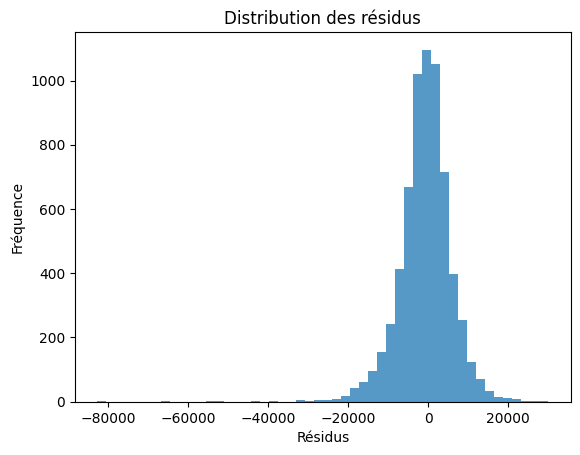

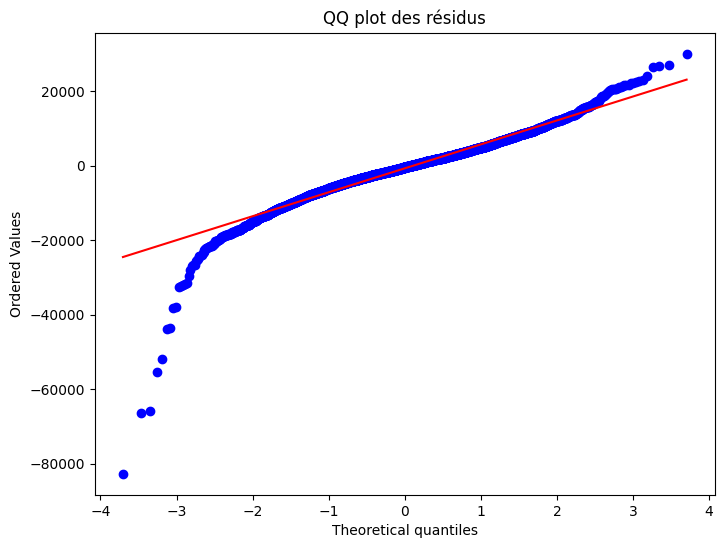

<Figure size 800x600 with 0 Axes>

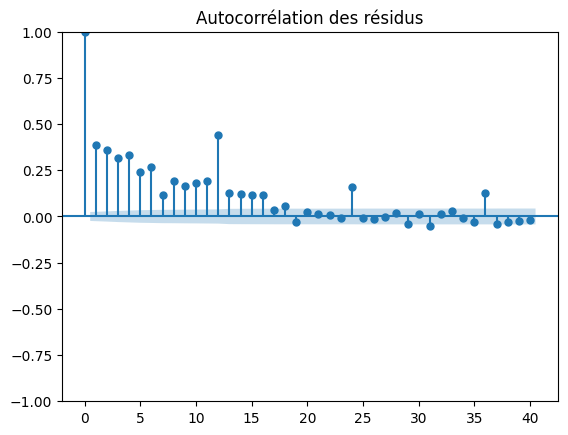

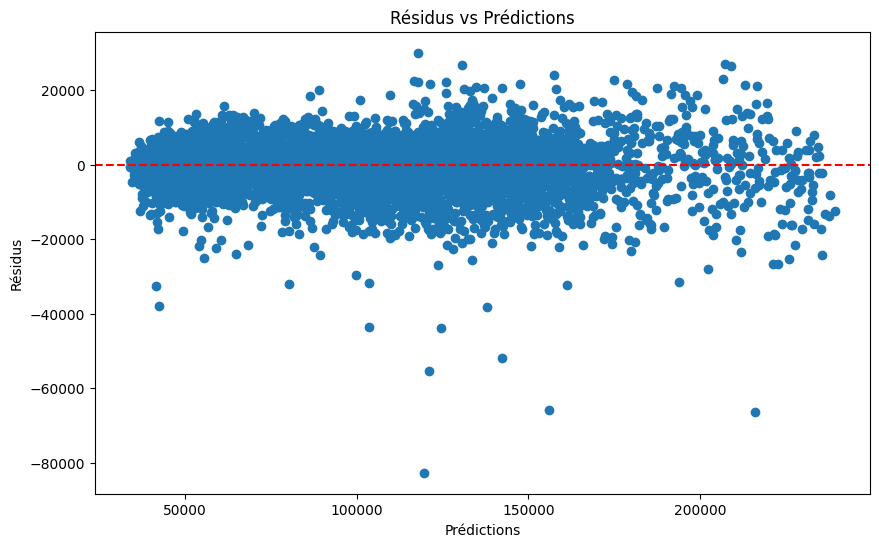

Skewness des résidus : -1.0645351270352912
Kurtosis des résidus : 9.513878582982858
Test Jarque-Bera: (25864.617481304016, 0.0, -1.0645351270352912, 12.513878582982858)
Test Shapiro-Wilk: ShapiroResult(statistic=0.9418519347433112, pvalue=6.774186484166186e-45)
Moyenne des résidus :  -706.3870471118512
Écart-type des résidus :  6620.575481404692


In [31]:
# Résidus (pour analyser la distribution)
residuals = y_test - y_pred_test

# Vérification de la distribution des résidus
plt.hist(residuals, bins=50, alpha=0.75)
plt.title("Distribution des résidus")
plt.xlabel("Résidus")
plt.ylabel("Fréquence")
plt.show()

# QQ plot des résidus
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ plot des résidus")
plt.show()

#ACF des résidus
plt.figure(figsize=(8, 6))
plot_acf(residuals, lags=40)  # Lags=40 pour observer les 40 premiers retards
plt.title("Autocorrélation des résidus")
plt.show()

# Tracer les résidus vs les prédictions
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Résidus vs Prédictions")
plt.xlabel("Prédictions")
plt.ylabel("Résidus")
plt.show()

# Calcul de la skewness et de la kurtosis des résidus
skewness_residus = skew(residuals)
kurtosis_residus = kurtosis(residuals)

print(f"Skewness des résidus : {skewness_residus}")
print(f"Kurtosis des résidus : {kurtosis_residus}")

#Test pour normalité des résidus et indépendance des résidus

print("Test Jarque-Bera:", jarque_bera(residuals))
print("Test Shapiro-Wilk:", shapiro(residuals))
acorr_ljungbox(residuals, lags=[10], return_df=True)

#Calcul moyenne et écart type des résidus : 
# Vérifier si les résidus sont normalement distribués
print("Moyenne des résidus : ", np.mean(residuals))
print("Écart-type des résidus : ", np.std(residuals))

In [33]:
# Ajouter les prédictions au DataFrame transformed
df_transformed.loc[X_train.index, "pred"] = y_pred_train
df_transformed.loc[X_test.index, "pred"] = y_pred_test

# Assurer que la colonne 'Date' est au bon format
df_transformed['Date'] = pd.to_datetime(df_transformed['Date'])

# Train
graph_train_df = df_transformed.loc[X_train.index].groupby("Date", as_index=False).agg({
    "Consommation (MWh)": "sum", 
    "pred": "sum"  # Agréger les prédictions sur l'ensemble de train
})

# Test
graph_test_df = df_transformed.loc[X_test.index].groupby("Date", as_index=False).agg({
    "Consommation (MWh)": "sum", 
    "pred": "sum"  # Agréger les prédictions sur l'ensemble de test
})


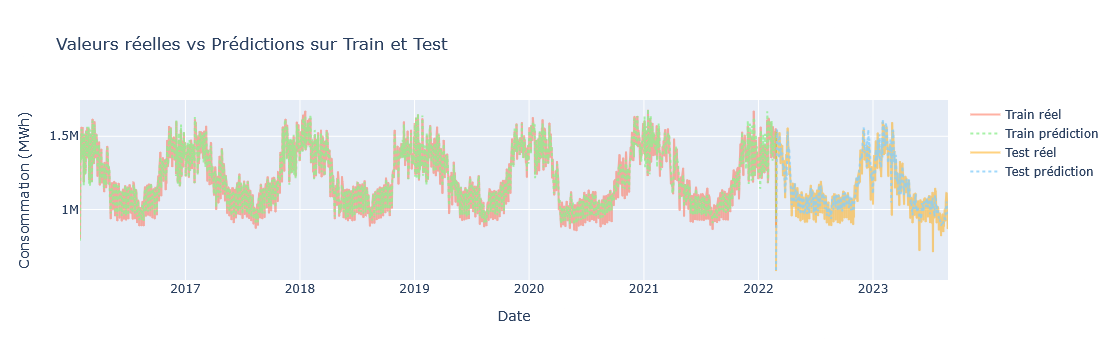

In [39]:
# Créer la figure
fig = go.Figure()

# Ajouter la trace pour les valeurs réelles sur le train (rouge pâle)
fig.add_trace(go.Scatter(
    x=graph_train_df['Date'], y=graph_train_df['Consommation (MWh)'], 
    mode='lines', name='Train réel', line=dict(color='rgba(255, 99, 71, 0.5)', width=2)  # Rouge pâle
))

# Ajouter la trace pour les prédictions sur le train (vert plus foncé)
fig.add_trace(go.Scatter(
    x=graph_train_df['Date'], y=graph_train_df['pred'], 
    mode='lines', name='Train prédiction', line=dict(color='rgba(144, 238, 144, 0.8)', dash='dot', width=2)  # Vert plus foncé (A=0.8)
))

# Ajouter la trace pour les valeurs réelles sur le test (orange pâle)
fig.add_trace(go.Scatter(
    x=graph_test_df['Date'], y=graph_test_df['Consommation (MWh)'], 
    mode='lines', name='Test réel', line=dict(color='rgba(255, 165, 0, 0.5)', width=2)  # Orange pâle
))

# Ajouter la trace pour les prédictions sur le test (bleu plus foncé)
fig.add_trace(go.Scatter(
    x=graph_test_df['Date'], y=graph_test_df['pred'], 
    mode='lines', name='Test prédiction', line=dict(color='rgba(135, 206, 250, 0.8)', dash='dot', width=2)  # Bleu plus foncé (A=0.8)
))

# Personnalisation du graphique
fig.update_layout(
    title='Valeurs réelles vs Prédictions sur Train et Test',
    xaxis_title='Date',
    yaxis_title='Consommation (MWh)',
    showlegend=True
)

# Afficher le graphique
fig.show()


### Modèle LGBM

Utilisation du grid search

In [384]:
# Définir le modèle LightGBM
model_lgb = lgb.LGBMRegressor(random_state=42)

# Définir les hyperparamètres à tester avec GridSearchCV
param_grid_lgb = {
    'n_estimators': [200, 500],  # Nombre d'estimateurs
    'learning_rate': [0.01, 0.05, 0.1],  # Taux d'apprentissage
    'max_depth': [3,5, 7],  # Profondeur des arbres
    'num_leaves': [31, 40, 50],  # Nombre de feuilles par arbre
    'colsample_bytree': [0.7, 0.8, 1.0],  # Proportion de features pour chaque arbre
    'subsample': [0.8, 1.0]  # Proportion d'échantillons utilisés pour chaque arbre
}

# GridSearchCV : recherche exhaustive des meilleurs paramètres
grid_search_lgb = GridSearchCV(estimator=model_lgb, param_grid=param_grid_lgb, 
                               cv=3, scoring='neg_mean_absolute_error', 
                               n_jobs=-1, verbose=1)

# Entraîner le modèle avec la recherche sur la grille
grid_search_lgb.fit(X_train, y_train)

# Afficher les meilleurs paramètres trouvés
print(f"Meilleurs paramètres pour LightGBM : {grid_search_lgb.best_params_}")

# Utiliser le modèle optimal pour faire des prédictions
best_model_lgb = grid_search_lgb.best_estimator_

# Validation croisée avec TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

mae_scores, mse_scores, mape_scores, r2_scores = [], [], [], []

for train_index, test_index in tscv.split(X_train):
    X_train_iter, X_test_iter = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_iter, y_test_iter = y_train.iloc[train_index], y_train.iloc[test_index]

    # Entraînement avec le meilleur modèle trouvé par GridSearchCV
    best_model_lgb.fit(X_train_iter, y_train_iter)

    # Prédictions
    y_pred = best_model_lgb.predict(X_test_iter)

    # Calcul des métriques
    mae = mean_absolute_error(y_test_iter, y_pred)
    mse = mean_squared_error(y_test_iter, y_pred)
    mape = np.mean(np.abs((y_test_iter - y_pred) / y_test_iter)) * 100
    r2 = r2_score(y_test_iter, y_pred)

    mae_scores.append(mae)
    mse_scores.append(mse)
    mape_scores.append(mape)
    r2_scores.append(r2)

# Moyennes des métriques
print(f"Validation croisée (GridSearchCV pour LightGBM) :")
print(f"MAE moyen : {np.mean(mae_scores)}")
print(f"MAPE moyen : {np.mean(mape_scores)}")
print(f"MSE moyen : {np.mean(mse_scores)}")
print(f"R² moyen : {np.mean(r2_scores)}")

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Meilleurs paramètres pour LightGBM : {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'num_leaves': 40, 'subsample': 0.8}
Validation croisée (GridSearchCV pour LightGBM) :
MAE moyen : 4364.779272464748
MAPE moyen : 4.60688476820923
MSE moyen : 34016210.11842433
R² moyen : 0.983799237642863


In [53]:
# Sauvegarder le modèle 'best_model_lgb' dans un fichier
joblib.dump(best_model_lgb, 'best_model_lgbm.pkl')

In [47]:
# Charger le modèle sauvegardé
best_model_loaded= joblib.load('best_model_lgbm.pkl')

In [49]:
# Prédire sur l'ensemble de test et de train
y_pred_train = best_model_loaded.predict(X_train)
y_pred_test = best_model_loaded.predict(X_test)

# Calcul des métriques sur l'ensemble de train
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100  # MAPE en %

# Calcul des métriques sur l'ensemble de test
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100  # MAPE en %


# Affichage des résultats sur le test et le train

print(f"MAE train : {mae_train}")
print(f"MSE train: {mse_train}")
print(f"R² train : {r2_train}")
print(f"MAPE train : {mape_train}%")

print(f"MAE test : {mae_test}")
print(f"MSE test : {mse_test}")
print(f"R² test : {r2_test}")
print(f"MAPE test : {mape_test}%")

MAE train : 2822.8491841148943
MSE train: 15030236.284654276
R² train : 0.9928975646251125
MAPE train : 3.101979232314049%
MAE test : 4880.967417750925
MSE test : 46515353.64367926
R² test : 0.9752328235232935
MAPE test : 6.076982827754325%


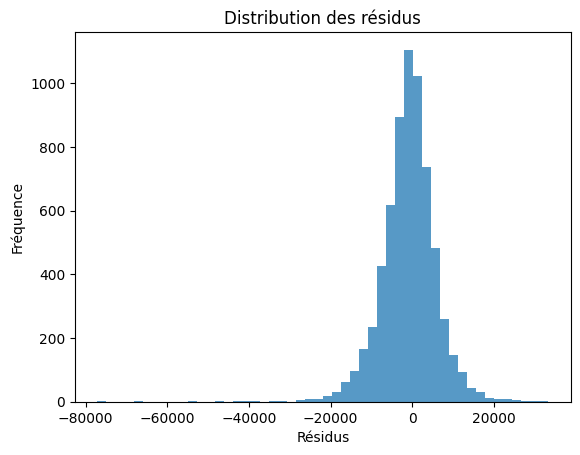

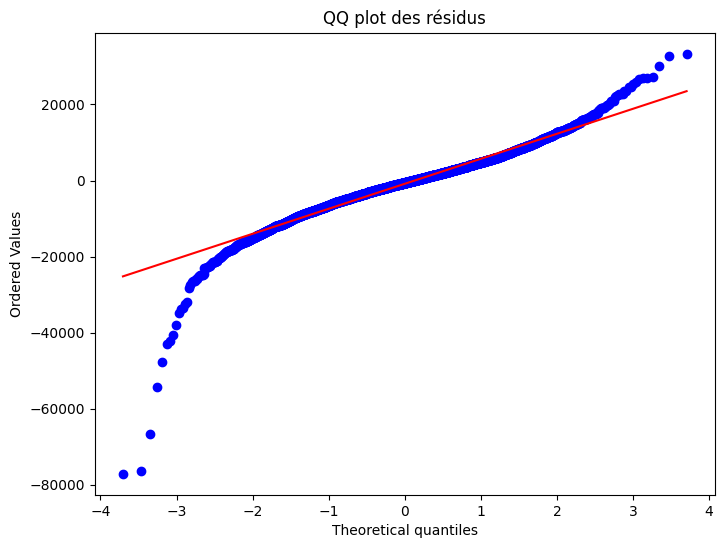

<Figure size 800x600 with 0 Axes>

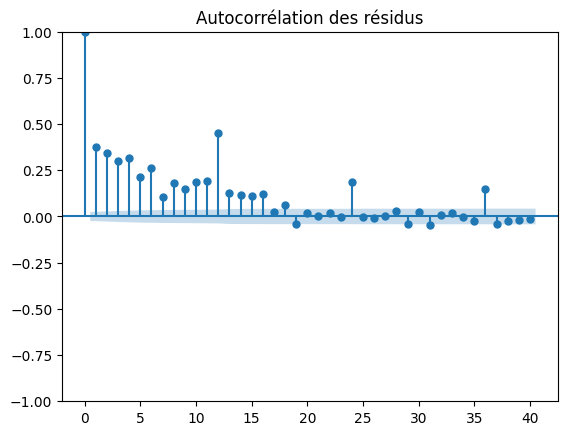

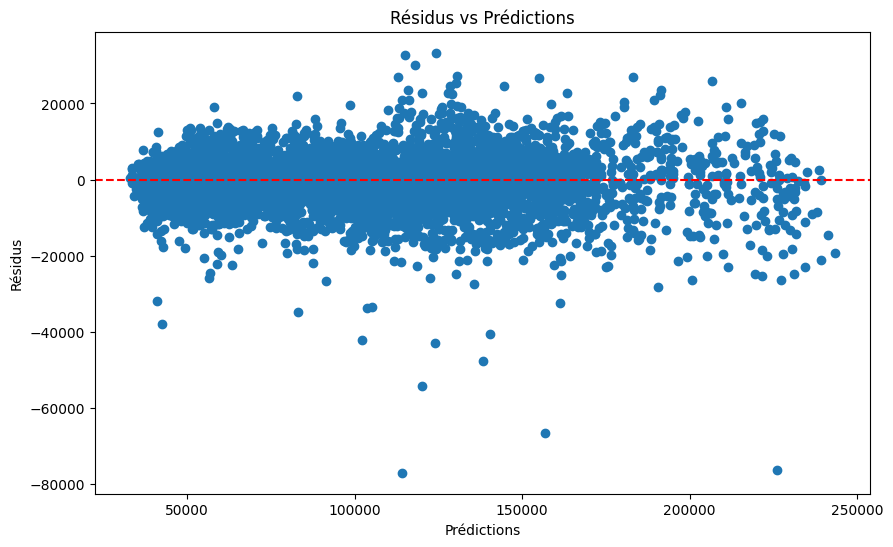

Skewness des résidus : -0.9114811632665651
Kurtosis des résidus : 9.014820317759904
Test Jarque-Bera: (23019.101917609674, 0.0, -0.9114811632665651, 12.014820317759904)
Test Shapiro-Wilk: ShapiroResult(statistic=0.9438087234134315, pvalue=2.4142925061847615e-44)
Moyenne des résidus :  -849.7962314692695
Écart-type des résidus :  6767.067312260151


In [55]:
# Résidus (pour analyser la distribution)
residuals = y_test - y_pred_test

# Vérification de la distribution des résidus
plt.hist(residuals, bins=50, alpha=0.75)
plt.title("Distribution des résidus")
plt.xlabel("Résidus")
plt.ylabel("Fréquence")
plt.show()

# QQ plot des résidus
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ plot des résidus")
plt.show()

#ACF des résidus
plt.figure(figsize=(8, 6))
plot_acf(residuals, lags=40)  # Lags=40 pour observer les 40 premiers retards
plt.title("Autocorrélation des résidus")
plt.show()

# Tracer les résidus vs les prédictions
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Résidus vs Prédictions")
plt.xlabel("Prédictions")
plt.ylabel("Résidus")
plt.show()

# Calcul de la skewness et de la kurtosis des résidus
skewness_residus = skew(residuals)
kurtosis_residus = kurtosis(residuals)

print(f"Skewness des résidus : {skewness_residus}")
print(f"Kurtosis des résidus : {kurtosis_residus}")

#Test pour normalité des résidus et indépendance des résidus

print("Test Jarque-Bera:", jarque_bera(residuals))
print("Test Shapiro-Wilk:", shapiro(residuals))
acorr_ljungbox(residuals, lags=[10], return_df=True)

#Calcul moyenne et écart type des résidus : 
# Vérifier si les résidus sont normalement distribués
print("Moyenne des résidus : ", np.mean(residuals))
print("Écart-type des résidus : ", np.std(residuals))

In [57]:
# Ajouter les prédictions au DataFrame transformed
df_transformed.loc[X_train.index, "pred"] = y_pred_train
df_transformed.loc[X_test.index, "pred"] = y_pred_test

# Assurer que la colonne 'Date' est au bon format
df_transformed['Date'] = pd.to_datetime(df_transformed['Date'])

# Pour le train
graph_train_df = df_transformed.loc[X_train.index].groupby("Date", as_index=False).agg({
    "Consommation (MWh)": "sum",  # Si tu veux une somme des consommations
    "pred": "sum"  # Agréger les prédictions sur l'ensemble de train
})

# Pour le test
graph_test_df = df_transformed.loc[X_test.index].groupby("Date", as_index=False).agg({
    "Consommation (MWh)": "sum",  # Même chose pour le test
    "pred": "sum"  # Agréger les prédictions sur l'ensemble de test
})

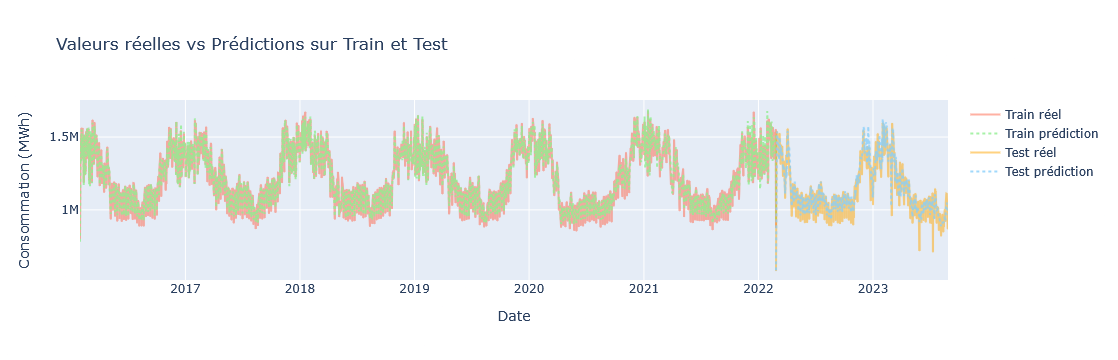

In [59]:
# Créer la figure
fig = go.Figure()

# Ajouter la trace pour les valeurs réelles sur le train (rouge pâle)
fig.add_trace(go.Scatter(
    x=graph_train_df['Date'], y=graph_train_df['Consommation (MWh)'], 
    mode='lines', name='Train réel', line=dict(color='rgba(255, 99, 71, 0.5)', width=2)  
))

# Ajouter la trace pour les prédictions sur le train (vert)
fig.add_trace(go.Scatter(
    x=graph_train_df['Date'], y=graph_train_df['pred'], 
    mode='lines', name='Train prédiction', line=dict(color='rgba(144, 238, 144, 0.8)', dash='dot', width=2)  
))

# Ajouter la trace pour les valeurs réelles sur le test (orange pâle)
fig.add_trace(go.Scatter(
    x=graph_test_df['Date'], y=graph_test_df['Consommation (MWh)'], 
    mode='lines', name='Test réel', line=dict(color='rgba(255, 165, 0, 0.5)', width=2)  
))

# Ajouter la trace pour les prédictions sur le test (bleu)
fig.add_trace(go.Scatter(
    x=graph_test_df['Date'], y=graph_test_df['pred'], 
    mode='lines', name='Test prédiction', line=dict(color='rgba(135, 206, 250, 0.8)', dash='dot', width=2) 
))

# Personnalisation du graphique
fig.update_layout(
    title='Valeurs réelles vs Prédictions sur Train et Test',
    xaxis_title='Date',
    yaxis_title='Consommation (MWh)',
    showlegend=True
)

# Afficher le graphique
fig.show()


Ajustements manuels suite au grid search : n'a pas donné d'amélioration par rapport aux résultats du grid search

In [478]:
model = LGBMRegressor(
    n_estimators=500,         # Plus d'arbres pour améliorer la stabilité (à ajuster si overfitting)
    learning_rate=0.1,        # Petit taux d’apprentissage pour plus de précision
    max_depth=7,               # Contrôle la complexité des arbres (évite l’overfitting)
    num_leaves=60,             # Nombre de feuilles par arbre (impacte la complexité)
    min_child_samples=20,      # Nombre minimum d’échantillons dans une feuille
    subsample=0.8,             # Échantillonnage des lignes pour réduire le surapprentissage
    colsample_bytree=0.8, # Échantillonnage des features (prévention de l'overfitting)
    lambda_l1=  0.2,
    lambda_l2 = 0.2,
    random_state=42,
    verbose=-1                
)

nb_splits = 3

# Initialize TimeSeriesSplit cross-validation
tscv = TimeSeriesSplit(n_splits=nb_splits)

# Variables pour stocker les scores
mae_scores = []
mape_scores = []
mse_scores = []
r2_scores = []


# Train RandomForestRegressor with cross-validation
for i, (train_index, test_index) in enumerate(tscv.split(X_train)):

    X_train_iter, X_test_iter = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_iter, y_test_iter = y_train.iloc[train_index], y_train.iloc[test_index]

    model.fit(X_train_iter, y_train_iter, eval_set=[(X_test_iter, y_test_iter)],
             callbacks=[early_stopping(50)])
    #pour chaque fold: fiter un modèle et faire les prédictions

    # Make predictions
    y_pred = model.predict(X_test_iter)

    # Calcul des métriques de performance pour cette itération de validation croisée
    mae = mean_absolute_error(y_test_iter, y_pred)
    mse = mean_squared_error(y_test_iter, y_pred)
    mape = np.mean(np.abs((y_test_iter - y_pred) / y_test_iter)) * 100
    r2 = r2_score(y_test_iter, y_pred)

    # Ajouter les scores à la liste des scores
    mae_scores.append(mae)
    mse_scores.append(mse)
    mape_scores.append(mape)
    r2_scores.append(r2)

# Calcul des moyennes des scores de la validation croisée
print(f"Validation croisée (TimeSeriesSplit avec {nb_splits} splits) :")
print(f"MAE moyen : {np.mean(mae_scores)}")
print(f"MSE moyen : {np.mean(mse_scores)}")
print(f"MAPE moyen : {np.mean(mape_scores)}")
print(f"R² moyen : {np.mean(r2_scores)}")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[337]	valid_0's l2: 3.84998e+07
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[300]	valid_0's l2: 3.10007e+07
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[255]	valid_0's l2: 3.29094e+07
Validation croisée (TimeSeriesSplit avec 3 splits) :
MAE moyen : 4376.02002850173
MSE moyen : 34136608.26901082
MAPE moyen : 4.636125600323854
R² moyen : 0.9837517361485565


In [480]:
# Prédire sur l'ensemble de test et de train
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calcul des métriques sur l'ensemble de train
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100  # MAPE en %

# Calcul des métriques sur l'ensemble de test
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100  # MAPE en %


# Affichage des résultats sur le test et le train

print(f"MAE train : {mae_train}")
print(f"MSE train: {mse_train}")
print(f"R² train : {r2_train}")
print(f"MAPE train : {mape_train}%")

print(f"MAE test : {mae_test}")
print(f"MSE test : {mse_test}")
print(f"R² test : {r2_test}")
print(f"MAPE test : {mape_test}%")

MAE train : 3086.233858114878
MSE train: 17462636.11730116
R² train : 0.9917481507177011
MAPE train : 3.3860859431142565%
MAE test : 4898.716737150922
MSE test : 46651665.715567306
R² test : 0.9751602439366431
MAPE test : 6.119677759847273%
